# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [99]:
# Import your libraries:

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [102]:
#Create a connection with create_engine to MySQL Workbench:
import mysql.connector
#use a text file to initiate password
password = None
with open(r"C:\Users\somoy\Desktop\Olagoke\Data Science\Iron Hack\Secret.txt", 'r') as file:
    for line in file:
        if line.startswith('mysql:'):
            password = line.split(': ')[1].strip()
            break
#open a connection between python and mysql
cnx = mysql.connector.connect(user = "root", password = password, database = "wholesale_customers", port = 3306)

In [104]:
#check for connection if still active
cnx.is_connected()

True

In [106]:
#setup a carrier or communicator between the sql and python
cursor = cnx.cursor()

#setup a query in SQL
query = ("SELECT * FROM wholesale_customers_data;")

#excecute the query
cursor.execute(query)

#retrieve all rows from the executed query
data = cursor.fetchall()

# Retrieve column names
column_names = cursor.column_names

# Create a DataFrame with the data and column names
customers = pd.DataFrame(data, columns=column_names)

# Display the DataFrame with correct column names
print(customers.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [108]:
# Close the cursor and connection
cursor.close()
cnx.close()
cnx.is_connected()

False

In [110]:
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [114]:
#What does each column mean?
customers.columns
#'Channel'- customer channel from 2 places namely Horeca (Hotel/Restaurant/Cafe) or Retail channel
#'Region' - Regions of sales from 3 places namely Lisbon, Oporto and other regions
#'Fresh', 'Milk', 'Grocery','Frozen','Detergents_Paper','Delicassen' - Different product categories

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [138]:
#Any categorical data to convert?
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [143]:
#Any missing data to remove?
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [120]:
#Column collinearity - any high correlations?
correlation_matrix = customers.corr()
correlation_matrix

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


<Axes: >

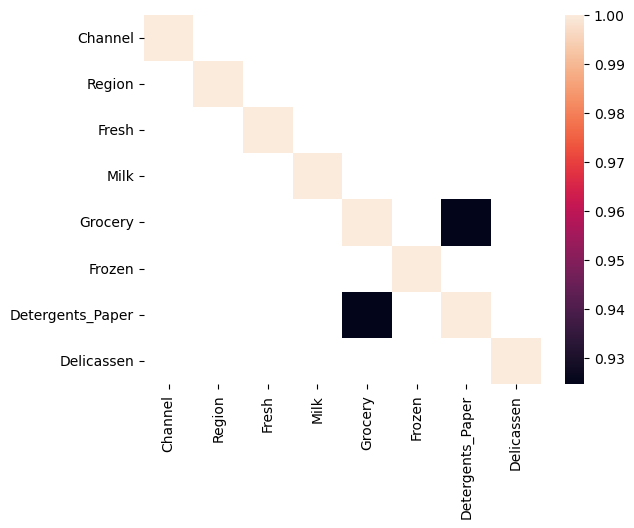

In [122]:
threshold = 0.8
mask = (correlation_matrix.abs() < threshold)
sns.heatmap(correlation_matrix, mask = mask)
#no strong correlation exist between the different variables

In [124]:
customers["Channel"].unique()

array([2, 1], dtype=int64)

<Axes: >

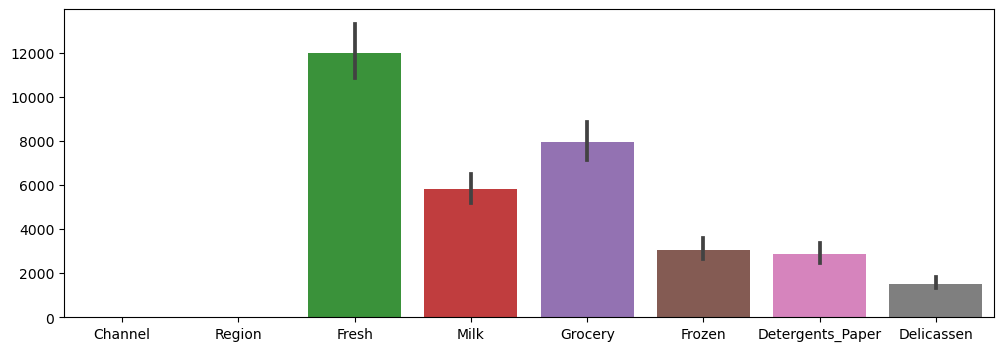

In [126]:
# Set the size of the plot
plt.figure(figsize=(12, 4))
sns.barplot(customers)

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [129]:
#The data is clean with no null values or a need for transformation

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [147]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [151]:
#using standardscaler to scale the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers)

In [155]:
customers_scale = pd.DataFrame(customers_scale, columns=customers.columns)
customers_scale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,1.448652,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,1.448652,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,-0.690297,0.590668,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,1.448652,0.590668,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...,...,...
435,-0.690297,0.590668,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,-0.690297,0.590668,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,1.448652,0.590668,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.690297,0.590668,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [ ]:
## Perform data clustering with K means

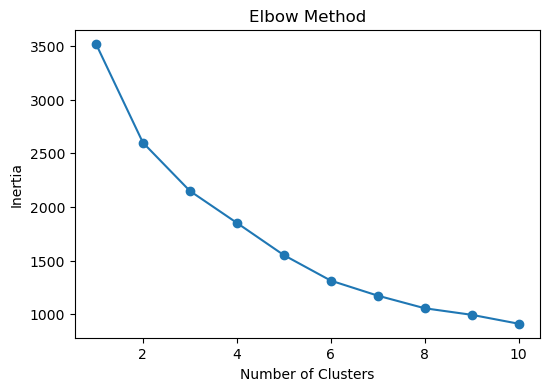

In [166]:
# first determine the optimal number of clusters using the Elbow Method
import warnings # Suppress all warnings
warnings.filterwarnings("ignore") # Suppress all warnings for cleaner output
# first determine the optimal number of clusters using the Elbow Method
from sklearn.cluster import KMeans
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_scale)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [181]:
# Applying K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
model = kmeans.fit(customers_scale)
#Add the Kmeal label to the customers dataset
customers['labels'] = model.labels_
print(customers)

     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  labels  labels_DBSCAN  
0          1338       0             -1  
1          1776       0             -1  


Count the values in `labels`.

In [187]:
customers.labels.value_counts()

labels
1    297
0    130
2     13
Name: count, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [179]:
from sklearn.cluster import DBSCAN
# Step 1: Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.5)

# Step 2: Fit the scaled data
dbscan.fit(customers_scale)

# Step 3: Access cluster labels from DBSCAN
dbscan_labels = dbscan.labels_

# Step 4: Assign the DBSCAN labels to the original DataFrame
customers['labels_DBSCAN'] = dbscan_labels

# Step 5: View the updated DataFrame with both clustering results
print(customers)

     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  labels  labels_DBSCAN  
0          1338       0             -1  
1          1776       0             -1  


Count the values in `labels_DBSCAN`.

In [189]:
# Your code here
customers.labels_DBSCAN.value_counts()

labels_DBSCAN
-1    255
 1    130
 5     22
 4      7
 6      6
 0      5
 3      5
 2      5
 7      5
Name: count, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

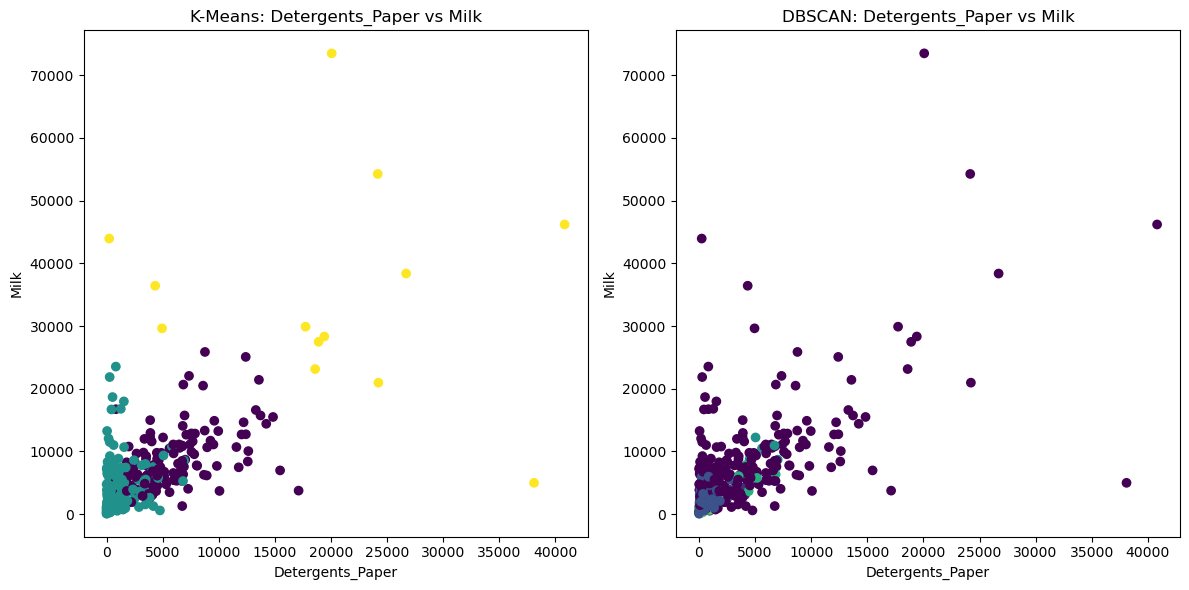

In [195]:
# Scatter plot for K-Means labels
plt.figure(figsize=(12, 6))

# K-Means plot
plt.subplot(1, 2, 1)
plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels'])
plt.title('K-Means: Detergents_Paper vs Milk')
plt.xlabel('Detergents_Paper')
plt.ylabel('Milk')

# Scatter plot for DBSCAN labels
plt.subplot(1, 2, 2)
plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels_DBSCAN'])
plt.title('DBSCAN: Detergents_Paper vs Milk')
plt.xlabel('Detergents_Paper')
plt.ylabel('Milk')

# Adjust layout
plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

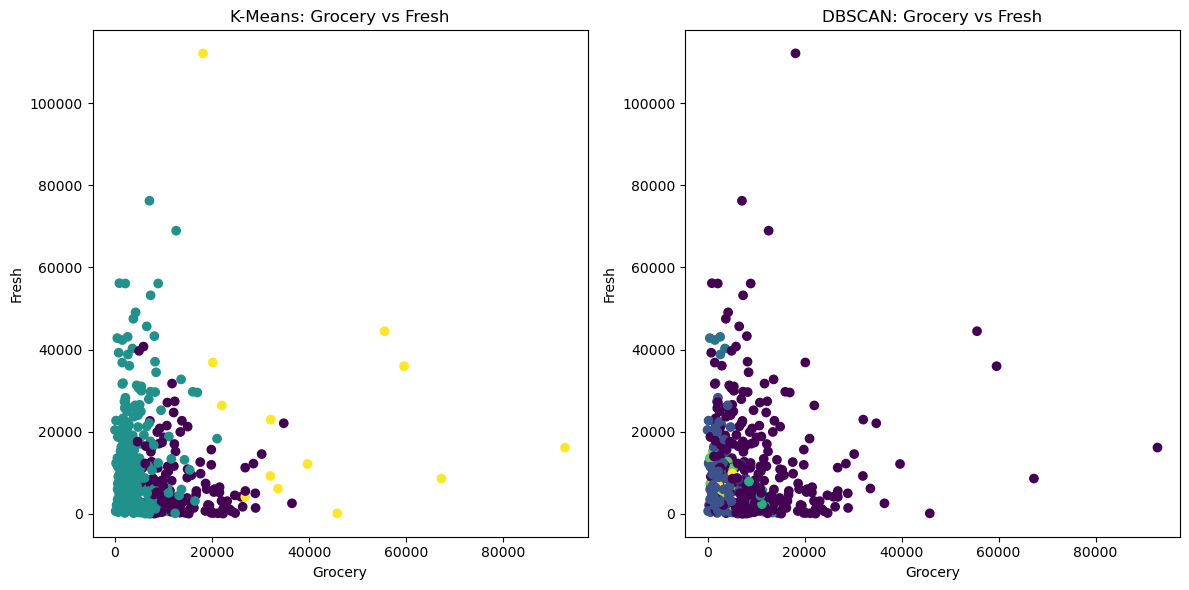

In [199]:
# Scatter plot for K-Means labels
plt.figure(figsize=(12, 6))

# K-Means plot
plt.subplot(1, 2, 1)
plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels'])
plt.title('K-Means: Grocery vs Fresh')
plt.xlabel('Grocery')
plt.ylabel('Fresh')

# Scatter plot for DBSCAN labels
plt.subplot(1, 2, 2)
plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels_DBSCAN'])
plt.title('DBSCAN: Grocery vs Fresh')
plt.xlabel('Grocery')
plt.ylabel('Fresh')

# Adjust layout
plt.tight_layout()
plt.show()


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

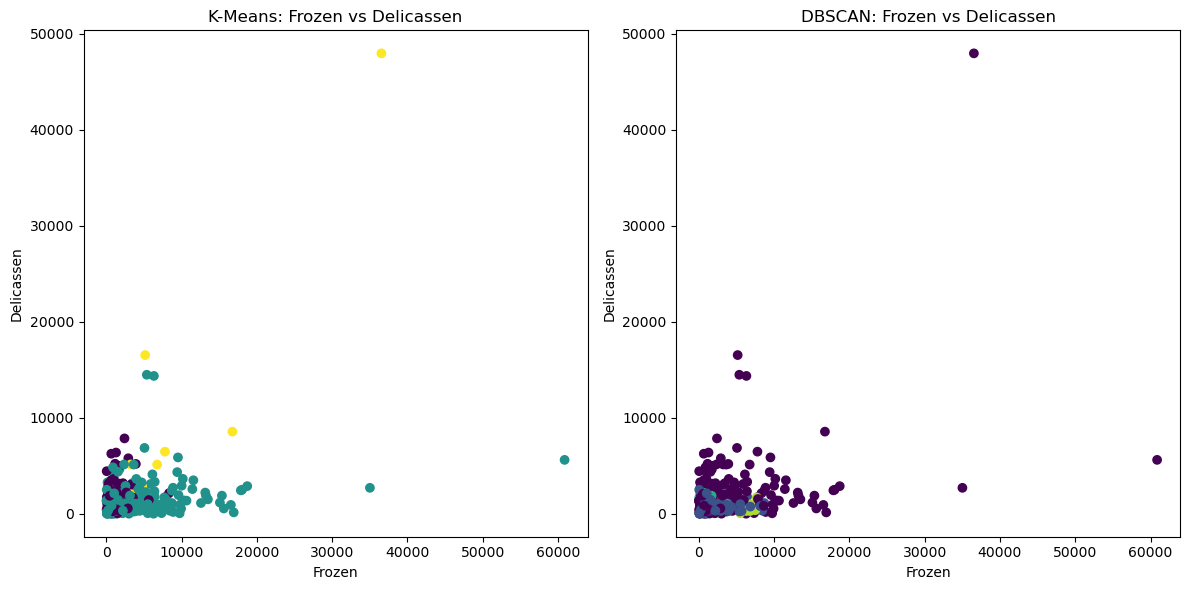

In [201]:
# Scatter plot for K-Means labels
plt.figure(figsize=(12, 6))

# K-Means plot
plt.subplot(1, 2, 1)
plt.scatter(customers['Frozen'], customers['Delicassen'], c=customers['labels'])
plt.title('K-Means: Frozen vs Delicassen')
plt.xlabel('Frozen')
plt.ylabel('Delicassen')

# Scatter plot for DBSCAN labels
plt.subplot(1, 2, 2)
plt.scatter(customers['Frozen'], customers['Delicassen'], c=customers['labels_DBSCAN'])
plt.title('DBSCAN: Frozen vs Delicassen')
plt.xlabel('Frozen')
plt.ylabel('Delicassen')

# Adjust layout
plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [209]:
# Group by K-Means labels and compute means
kmeans_means = customers.groupby('labels').mean()

# Group by DBSCAN labels and compute means
dbscan_means = customers.groupby('labels_DBSCAN').mean()

kmeans_means_df = pd.DataFrame(kmeans_means)
dbscan_means_df = pd.DataFrame(dbscan_means)

# Display the results
print("Means grouped by K-Means labels:\n")
print(kmeans_means_df)

print("\nMeans grouped by DBSCAN labels:\n")
print(dbscan_means_df)

Means grouped by K-Means labels:

         Channel    Region         Fresh          Milk       Grocery  \
labels                                                                 
0       2.000000  2.623077   8165.915385   8748.515385  13905.492308   
1       1.003367  2.505051  13075.898990   3218.737374   3855.696970   
2       1.846154  2.615385  25770.769231  35160.384615  41977.384615   

             Frozen  Detergents_Paper   Delicassen  labels_DBSCAN  
labels                                                             
0       1441.630769       5991.146154  1535.007692      -0.538462  
1       3620.400673        776.875421  1242.249158       0.646465  
2       6844.538462      19867.384615  7880.307692      -1.000000  

Means grouped by DBSCAN labels:

                Channel   Region         Fresh          Milk       Grocery  \
labels_DBSCAN                                                                
-1             1.490196  2.45098  13729.564706   8359.886275  11484.364706 

Which algorithm appears to perform better?

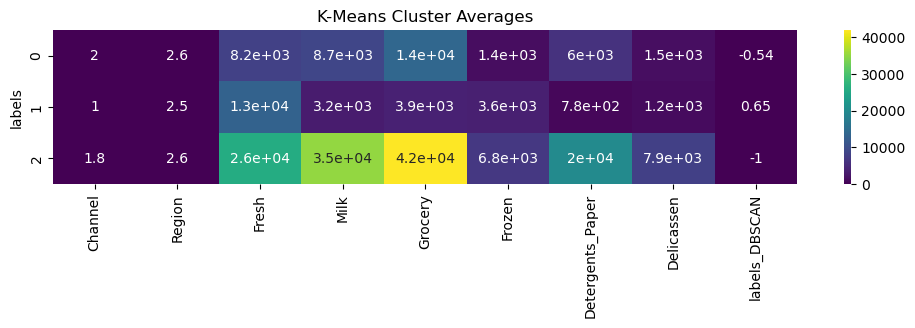

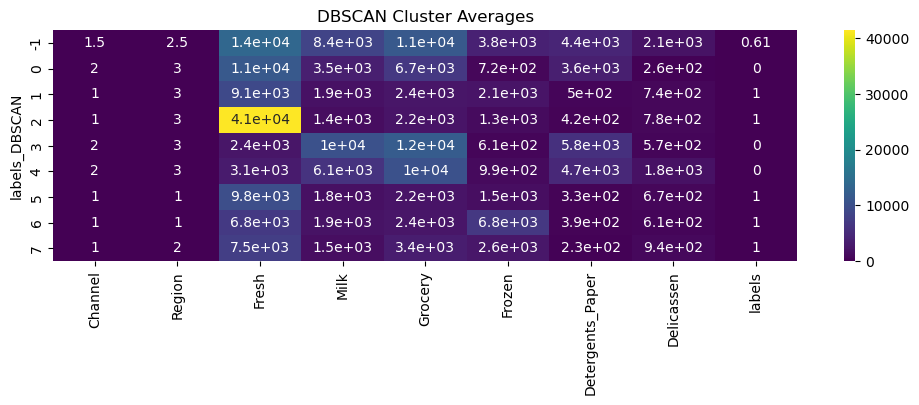

In [221]:
import seaborn as sns
plt.figure(figsize=(12, 2))
sns.heatmap(kmeans_means, annot=True, cmap='viridis')
plt.title("K-Means Cluster Averages")
plt.show()

plt.figure(figsize=(12, 3))
sns.heatmap(dbscan_means, annot=True, cmap='viridis')
plt.title("DBSCAN Cluster Averages")
plt.show()

In [ ]:
"""
K-Means Heatmap (Top): The clusters groups the data into distinct patterns with significant differences in means for features like Fresh, Milk, and Grocery.

DBSCAN Heatmap (Bottom): DBSCAN clusters also separate data points, but there are many smaller clusters, which makes it harder to interpret.

The K mean algorithm appears to perform better than the DBSCAN algorithm.
"""

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here